In [1]:
import os
import random
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt

In [2]:
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

PREPARED_DATASET = 'dataset/prepared/'

In [3]:
def load_prepared_data(file_name, target_length=1000):
    input_path = os.path.join(PREPARED_DATASET, file_name)
    df = pd.read_csv(input_path, sep="|", names=["x", "y"])
    y_raw = df["y"].values

    y_norm = (y_raw - np.min(y_raw)) / (np.max(y_raw) - np.min(y_raw))

    f = interp1d(np.linspace(0, 1, len(y_norm)), y_norm, kind='linear')
    x_new = np.linspace(0, 1, target_length)
    y_interp = f(x_new)

    return x_new, y_interp

In [4]:
# def create_mask_from_slope(y, threshold=0.001, min_length=2):
def create_mask_from_slope(y, threshold=0.001, min_length=2):
    dy = np.gradient(y)

    mask = np.abs(dy) > threshold 

    filtered_mask = np.zeros_like(mask)
    current_region = []

    for i in range(len(mask)):
        if mask[i]:
            current_region.append(i)
        else:
            if len(current_region) >= min_length:
                for idx in current_region:
                    filtered_mask[idx] = 1
            current_region = []

    if len(current_region) >= min_length:
        for idx in current_region:
            filtered_mask[idx] = 1

    return filtered_mask.astype(float)

In [5]:
file_names = ["norm.csv", "defect1.csv", "defect2.csv"]
X_signals = []
Y_masks = []

for file in file_names:
    x, y = load_prepared_data(file)
    X_signals.append(y)

    mask = create_mask_from_slope(y)
    Y_masks.append(mask)

X_signals = np.array(X_signals)[..., np.newaxis]  # (batch_size, length, channels)
Y_masks = np.array(Y_masks)[..., np.newaxis]
print(Y_masks)

[[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [0.]
  [0.]]

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [0.]
  [0.]]]


In [6]:
def create_model(input_length):
    model = Sequential([
        Conv1D(32, kernel_size=5, activation='relu', input_shape=(input_length, 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(input_length, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

In [7]:
# обучение
model = create_model(X_signals.shape[1])
model.summary()

model.fit(X_signals, Y_masks, epochs=20, batch_size=4, validation_split=0.2)

c:\Users\Y520\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 996, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 498, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 494, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 247, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15808)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,023,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │       129,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,163,048 (8.25 MB)

 Trainable params: 2,163,048 (8.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6933 - val_loss: 0.6926
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.6910 - val_loss: 0.6918
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.6873 - val_loss: 0.6907
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.6812 - val_loss: 0.6894
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.6721 - val_loss: 0.6880
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.6599 - val_loss: 0.6866
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.6450 - val_loss: 0.6853
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.6279 - val_loss: 0.6841
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.6096 - val_loss: 0.6832
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.5904 - val_loss: 0.6819
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.5701 - val_loss: 0.6794
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.5483 - val_loss:

In [8]:
def predict_key_points(model, file_name, max_regions=10):
    x, y = load_prepared_data(file_name)

    X = y.reshape(1, -1, 1)
    mask = model.predict(X)[0]

    threshold = 0.9
    key_indices = [i for i in range(len(mask)) if mask[i] > threshold]

    grouped_regions = []
    current_region = []
    for i in range(len(key_indices)):
        if not current_region or key_indices[i] - key_indices[i - 1] <= 10:
            current_region.append(key_indices[i])
        else:
            grouped_regions.append(current_region)
            current_region = [key_indices[i]]
    if current_region:
        grouped_regions.append(current_region)

    top_regions = sorted(grouped_regions, key=lambda r: len(r), reverse=True)[:max_regions]

    refined_centers = []
    for region in top_regions:
        right_edge = min(region)
        left_edge = max(region)

        max_shift = 50

        dy = np.gradient(y)

        while (
            right_edge < len(y) - 1 and
            dy[right_edge] >= 0 and
            y[right_edge] > 0.05 and
            right_edge <= max(region) - max_shift
        ):
            right_edge += 1

        while (
            left_edge < len(y) - 1 and
            dy[left_edge] <= 0 and
            y[left_edge] > 0.05 and
            left_edge <= min(region) + max_shift
        ):
            left_edge += 1

        center = int((left_edge + right_edge) / 2)
        refined_centers.append(center)

    plt.figure(figsize=(12, 4))
    plt.plot(x, y, label="Signal", color="black")
    for pt in refined_centers:
        plt.axvline(x[pt], color="pink", linestyle="--", linewidth=2,
                    label="Key Point" if pt == refined_centers[0] else "")
    plt.title(f"Key points in {file_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


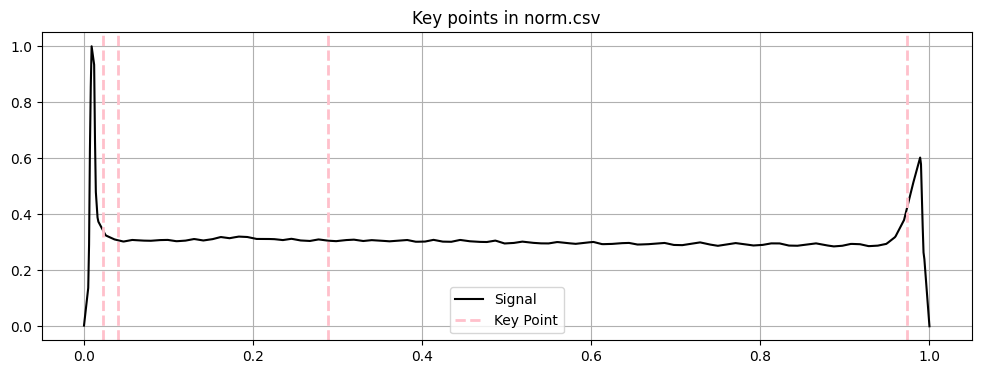

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


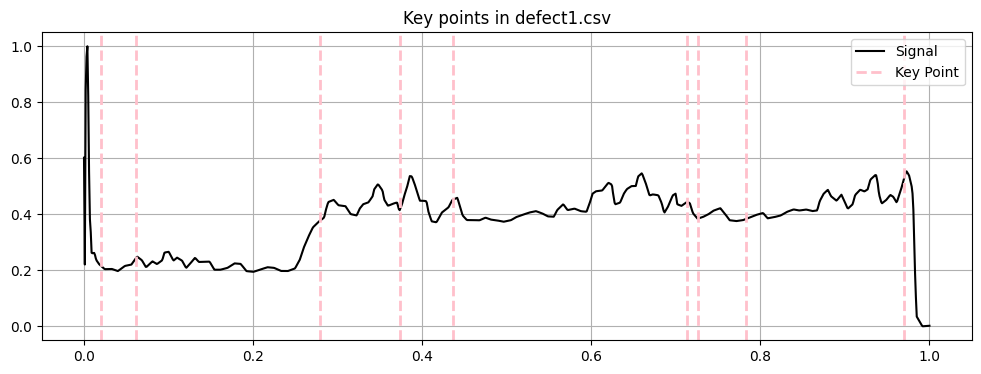

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


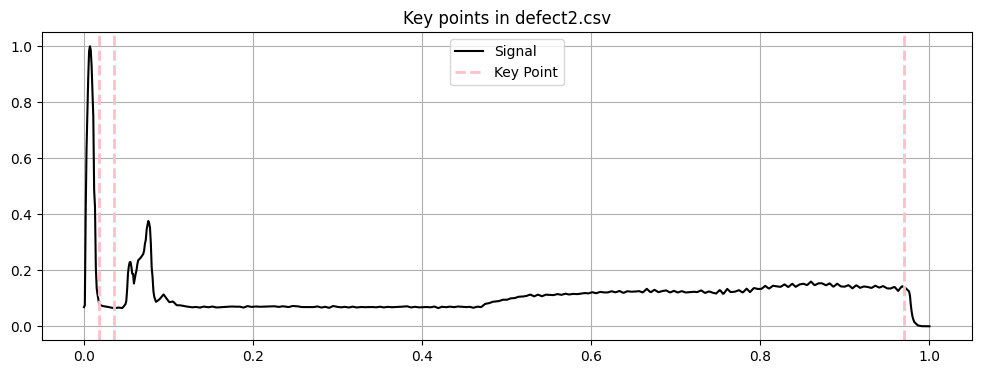

In [9]:
predict_key_points(model, "norm.csv")
predict_key_points(model, "defect1.csv")
predict_key_points(model, "defect2.csv")